In [1]:
import os
os.chdir('C:/Satyaki/Insofe_Rennes/MITH/ProblemDescription_and_Dataset')
os.getcwd()

'C:\\Satyaki\\Insofe_Rennes\\MITH\\ProblemDescription_and_Dataset'

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, date, time
from ipaddress import ip_address,ip_interface
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,RandomizedSearchCV

In [3]:
merchant_info_1=pd.read_csv('train_merchant_data.csv')
order_info_1=pd.read_csv('train_order_data.csv')
label_info_1=pd.read_csv('train.csv')

merchant_info_2=pd.read_csv('test_merchant_data.csv')
order_info_2=pd.read_csv('test_order_data.csv')
label_info_2=pd.read_csv('test.csv')

ip_book=pd.read_csv('ip_boundaries_countries.csv')

In [4]:
#viewing the datasets

In [5]:
merchant_info_1.head()

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address
0,1746213,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76
1,1746213,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169
2,1746213,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121
3,1746213,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186
4,1746213,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172


In [6]:
order_info_1.head()

,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Merchant_ID
0,126221,37cea9512f8d,2018-04-29 16:39:26,148,Direct,Credit Card,124231
1,115471,09f12e6efde2,2018-06-16 17:05:40,145,SEO,Credit Card,136178
2,151786,4e69e956e159,2018-10-26 18:00:46,62,Ads,Internet Banking,198611
3,140456,663443aaeb82,2018-12-12 05:41:52,28,SEO,Debit Card,127993
4,114721,99258810c121,2018-09-20 11:06:10,70,Ads,Credit Card,250146


In [7]:
label_info_1.head()

,Merchant_ID,Fraudster
0,221592,0
1,316935,1
2,38454,1
3,214437,1
4,296240,1


In [8]:
ip_book['lower_bound_ip_address']=ip_book['lower_bound_ip_address'].apply(lambda x:ip_address(x))
ip_book['upper_bound_ip_address']=ip_book['upper_bound_ip_address'].apply(lambda x:ip_address(x))
ip_book.shape

(138846, 3)

In [9]:
ip_book['ll']=ip_book['lower_bound_ip_address'].apply(lambda x: int(x))
ip_book['ul']=ip_book['upper_bound_ip_address'].apply(lambda x: int(x))
ip_book.head()

,lower_bound_ip_address,upper_bound_ip_address,country,ll,ul
0,1.0.0.0,1.0.0.255,Australia,16777216,16777471
1,1.0.1.0,1.0.1.255,China,16777472,16777727
2,1.0.2.0,1.0.3.255,China,16777728,16778239
3,1.0.4.0,1.0.7.255,Australia,16778240,16779263
4,1.0.8.0,1.0.15.255,China,16779264,16781311


In [10]:
print(merchant_info_1.shape)
print(order_info_1.shape)
print(label_info_1.shape)
print('--------------------')
print(merchant_info_2.shape)
print(order_info_2.shape)
print(label_info_2.shape)

(54213, 7)
(54213, 7)
(54213, 2)
--------------------
(13554, 7)
(13554, 7)
(13554, 1)


In [11]:
# consolidating the training data
df=merchant_info_1.merge(order_info_1,on='Merchant_ID')
train=df.merge(label_info_1,on='Merchant_ID')
del(df)
#train.set_index('Merchant_ID',inplace=True)
train.head()


,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster
0,1746213,50448,2018-05-01 21:15:11,VATQMMZTVOZUT,F,39,48.151.136.76,129697,3b8983a83c7b,2018-07-30 10:59:13,90,SEO,Debit Card,0
1,1746213,338754,2018-04-14 10:13:00,LJCILLBRQZNKS,M,35,94.9.145.169,117390,34b5eb921228,2018-06-15 11:19:47,98,SEO,Internet Banking,0
2,1746213,291127,2018-06-20 07:44:22,JFVHSUGKDAYZV,F,40,58.94.157.121,120162,41a1c86ff08b,2018-08-13 10:06:26,95,SEO,Credit Card,0
3,1746213,319919,2018-06-27 01:41:39,WFRXMPLQYXRMY,M,37,193.187.41.186,128228,e8c3ad80d916,2018-07-22 15:46:51,100,Direct,E-wallet,0
4,1746213,195911,2018-01-05 00:55:41,GGHKWMSWHCMID,F,27,125.96.20.172,136029,e71ab1f26785,2018-04-16 08:02:44,78,SEO,E-wallet,0


In [12]:
# consolidating test data
test=merchant_info_2.merge(order_info_2,on='Merchant_ID')
#test.set_index('Merchant_ID',inplace=True)
test.head()

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method
0,1746213,53637,2018-02-11 20:50:29,PTMLBENYMQCTV,F,40,134.162.124.62,157068,a032de091f51,2018-03-09 09:09:42,60,SEO,Credit Card
1,1746213,243517,2018-04-06 13:19:39,HMCLDZUZPWZRR,M,39,152.76.98.87,112534,0d563f0606d6,2018-06-13 20:11:19,28,SEO,Credit Card
2,1746213,343640,2018-01-12 16:47:49,VLGSMAPXISSEJ,M,23,31.202.3.255,148774,18fb0fa888b6,2018-04-14 04:19:36,75,Ads,Debit Card
3,1746213,69889,2018-02-19 21:58:52,ZINHISBBOKQXT,M,34,12.242.168.185,114528,ed1eb920d721,2018-04-01 13:55:44,98,SEO,Credit Card
4,1746213,125706,2018-05-17 15:50:19,WFKEAOTPHTYEO,M,20,26.61.210.47,120940,313dcf962627,2018-05-25 02:08:18,35,SEO,Credit Card


In [13]:
train.dtypes

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                    int64
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
Fraudster                      int64
dtype: object

In [14]:
train['Ecommerce_Provider_ID'].value_counts()

# since all transactions are through the same ecommerce provider, this column doesn't provide any additional value

1746213    54213
Name: Ecommerce_Provider_ID, dtype: int64

In [15]:
train['Registered_Device_ID'].value_counts()
# devices can be classified as returning or not

RDLIARTBSYNJX    9
QGWUOPUHKKOWQ    9
VGGTRBYDZMCPN    9
TCFHYPEGJMBIZ    9
RJEAMRBBMPWEA    9
                ..
BSIWYGOSZYKLU    1
JCKEYHSOMYAXM    1
BNSEYIQQCGNAE    1
INDMMWAJPLBGU    1
VRSPFEQBBFVRK    1
Name: Registered_Device_ID, Length: 51291, dtype: int64

In [16]:
train['Order_ID'].value_counts()
# all order ids are unique and hence the column can be dropped

8329d64c6b85    1
55d6486d46c6    1
612c3934d60d    1
c8ff329ec33f    1
13bd046026ae    1
               ..
417a639f31bd    1
8129296bade4    1
3a41657f76e4    1
83aedf177b87    1
417ae95176fe    1
Name: Order_ID, Length: 54213, dtype: int64

In [17]:
train['Customer_ID'].value_counts()
# customers can be classified as returning customer or not

154763    7
124702    7
111658    7
156576    7
113846    6
         ..
158719    1
121865    1
117771    1
128012    1
131072    1
Name: Customer_ID, Length: 34081, dtype: int64

In [18]:
train['Order_Source'].value_counts()

SEO       21884
Ads       21259
Direct    11070
Name: Order_Source, dtype: int64

In [19]:
train['Fraudster'].value_counts(normalize=True)

0    0.90731
1    0.09269
Name: Fraudster, dtype: float64

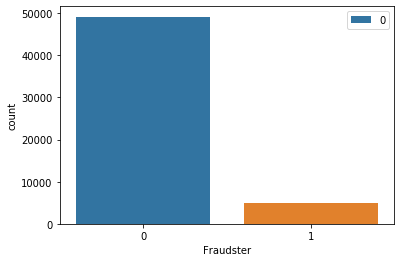

In [300]:
sns.countplot(train["Fraudster"])
plt.ylabel('count')
plt.legend({0:'Not fraud',1:'fraud'})
# fraud class is highly imbalanced

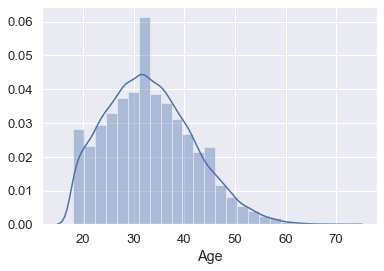

In [305]:
sns.distplot(train['Age'],bins=25)
# ages for the sample population is slightly right skewed

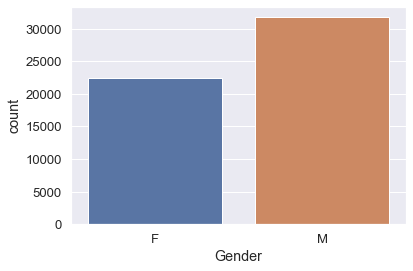

In [306]:
sns.countplot(train['Gender'])

In [20]:
train.describe(include='all')

,Ecommerce_Provider_ID,Merchant_ID,Merchant_Registration_Date,Registered_Device_ID,Gender,Age,IP_Address,Customer_ID,Order_ID,Date_of_Order,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster
count,54213.0,54213.000000,54213,54213,54213,54213.000000,54213,54213.000000,54213,54213,54213.000000,54213,54213,54213.00000
unique,NaN,NaN,54213,51291,2,NaN,52028,NaN,54213,54161,NaN,3,5,NaN
top,NaN,NaN,2018-08-01 04:48:51,RDLIARTBSYNJX,M,NaN,107.29.25.29,NaN,8329d64c6b85,2018-06-20 17:43:54,NaN,SEO,Credit Card,NaN
freq,NaN,NaN,1,9,31761,NaN,9,NaN,1,2,NaN,21884,21844,NaN
mean,1746213.0,200395.176212,NaN,NaN,NaN,33.122240,NaN,137966.285208,NaN,NaN,92.230240,NaN,NaN,0.09269
std,0.0,115398.486895,NaN,NaN,NaN,8.630091,NaN,15563.516156,NaN,NaN,45.673263,NaN,NaN,0.29000
min,1746213.0,2.000000,NaN,NaN,NaN,18.000000,NaN,111234.000000,NaN,NaN,22.000000,NaN,NaN,0.00000
25%,1746213.0,100997.000000,NaN,NaN,NaN,27.000000,NaN,124471.000000,NaN,NaN,55.000000,NaN,NaN,0.00000
50%,1746213.0,200574.000000,NaN,NaN,NaN,32.000000,NaN,137864.000000,NaN,NaN,88.000000,NaN,NaN,0.00000
75%,1746213.0,300407.000000,NaN,NaN,NaN,39.000000,NaN,151405.000000,NaN,NaN,122.000000,NaN,NaN,0.00000


In [21]:
train['IP_Address']=train['IP_Address'].apply(lambda x: ip_address(x)).apply(lambda x: int(x))

In [22]:
%%time
train['x']=train['IP_Address'].apply(lambda x: ip_book.query('ll<=@x<=ul').index.values).apply(lambda x: x[0] if len(x) else -1)


Wall time: 3min 57s


In [23]:
%%time
test['IP_Address']=test['IP_Address'].apply(lambda x: ip_address(x)).apply(lambda x: int(x))
test['x']=test['IP_Address'].apply(lambda x: ip_book.query('ll<=@x<=ul').index.values).apply(lambda x: x[0] if len(x) else -1)


Wall time: 58.8 s


# finalizing dataframes

In [225]:
to_drop=['x','ll','ul','lower_bound_ip_address','upper_bound_ip_address','Ecommerce_Provider_ID','Order_ID','Merchant_Registration_Date','Date_of_Order']
final_1=pd.merge(train.drop('IP_Address',1),ip_book.filter(regex=r'^((?!.?ip_range_).*)$'),left_on='x',right_index=True,how='left').drop(to_drop,1)
final_2=pd.merge(test.drop('IP_Address',1),ip_book.filter(regex=r'^((?!.?ip_range_).*)$'),left_on='x',right_index=True,how='left').drop(to_drop,1)


In [226]:
final_1.head()


,Merchant_ID,Registered_Device_ID,Gender,Age,Customer_ID,Order_Value_USD,Order_Source,Order_Payment_Method,Fraudster,country
0,50448,VATQMMZTVOZUT,F,39,129697,90,SEO,Debit Card,0,United States
1,338754,LJCILLBRQZNKS,M,35,117390,98,SEO,Internet Banking,0,United Kingdom
2,291127,JFVHSUGKDAYZV,F,40,120162,95,SEO,Credit Card,0,Japan
3,319919,WFRXMPLQYXRMY,M,37,128228,100,Direct,E-wallet,0,Austria
4,195911,GGHKWMSWHCMID,F,27,136029,78,SEO,E-wallet,0,China


In [227]:
print(final_1.shape)
print(final_2.shape)

(54213, 10)
(13554, 9)


In [228]:
#final_1.loc[final_1['Fraudster']==1,['country']].describe()
final_1.groupby('Fraudster')['country'].value_counts()

Fraudster  country          
0          United States        18991
           China                 3902
           Japan                 2377
           United Kingdom        1447
           Korea Republic of     1291
                                ...  
1          Macedonia                1
           Malaysia                 1
           Malta                    1
           Sudan                    1
           Turkmenistan             1
Name: country, Length: 196, dtype: int64

# Train_test_split

In [229]:
# train test split
X,y=final_1.loc[:,final_1.columns!='Fraudster'],final_1['Fraudster']
X_test,X_train,y_test,y_train=train_test_split(X,y,test_size=0.9,random_state=123)


In [217]:
'''# converting columns to correct type
X_train['Merchant_Registration_Date']=X_train['Merchant_Registration_Date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
X_test['Merchant_Registration_Date']=X_test['Merchant_Registration_Date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

X_train['Date_of_Order']=X_train['Date_of_Order'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
X_test['Date_of_Order']=X_test['Date_of_Order'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))'''

"# converting columns to correct type\nX_train['Merchant_Registration_Date']=X_train['Merchant_Registration_Date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))\nX_test['Merchant_Registration_Date']=X_test['Merchant_Registration_Date'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))\n\nX_train['Date_of_Order']=X_train['Date_of_Order'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))\nX_test['Date_of_Order']=X_test['Date_of_Order'].apply(lambda x:datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))"

In [230]:
# identify frequent devices and customers
def fun1(x):
    if x>1:
        return 1
    else:
        return 0


def fun2(A,x):
    'A is dataframe'
    'x=list of columns for which count is needed'
    f2=A
    for i in x:
        a=pd.DataFrame(A[i].value_counts()).reset_index()
        a.columns=[i,i+'_count']
        f2=pd.merge(f2,a,on=i,how='left')
        f2.drop(i,axis=1,inplace=True)
    return f2




X_train=fun2(X_train,['Registered_Device_ID','Customer_ID'])
X_test=fun2(X_test,['Registered_Device_ID','Customer_ID'])    
final_2=fun2(final_2,['Registered_Device_ID','Customer_ID'])



In [231]:
X_train['repeat_customer']=X_train['Customer_ID_count'].apply(fun1)
X_train['repeat_device']=X_train['Registered_Device_ID_count'].apply(fun1)
X_train.drop(['Customer_ID_count','Registered_Device_ID_count'],axis=1,inplace=True)
X_train.head()

,Merchant_ID,Gender,Age,Order_Value_USD,Order_Source,Order_Payment_Method,country,repeat_customer,repeat_device
0,361689,M,42,48,Ads,Cash On Delivery,Germany,1,0
1,389557,F,39,58,SEO,Credit Card,NaN,1,0
2,116849,F,25,270,SEO,Credit Card,France,0,0
3,101971,M,21,112,Ads,Internet Banking,Thailand,1,0
4,283208,M,20,72,Ads,Debit Card,Germany,0,0


In [232]:
X_test['repeat_customer']=X_test['Customer_ID_count'].apply(fun1)
X_test['repeat_device']=X_test['Registered_Device_ID_count'].apply(fun1)
X_test.drop(['Customer_ID_count','Registered_Device_ID_count'],axis=1,inplace=True)
X_test.head()

,Merchant_ID,Gender,Age,Order_Value_USD,Order_Source,Order_Payment_Method,country,repeat_customer,repeat_device
0,201001,M,23,125,SEO,E-wallet,China,0,0
1,169867,M,35,40,Direct,Cash On Delivery,Canada,0,0
2,3999,M,38,102,SEO,Debit Card,NaN,1,0
3,262131,F,29,115,SEO,Credit Card,United States,0,0
4,20588,M,26,112,SEO,Credit Card,NaN,0,0


In [233]:
final_2['repeat_customer']=final_2['Customer_ID_count'].apply(fun1)
final_2['repeat_device']=final_2['Registered_Device_ID_count'].apply(fun1)
final_2.drop(['Customer_ID_count','Registered_Device_ID_count'],axis=1,inplace=True)
final_2.head()

,Merchant_ID,Gender,Age,Order_Value_USD,Order_Source,Order_Payment_Method,country,repeat_customer,repeat_device
0,53637,F,40,60,SEO,Credit Card,United States,0,0
1,243517,M,39,28,SEO,Credit Card,Australia,1,0
2,343640,M,23,75,Ads,Debit Card,Ukraine,0,0
3,69889,M,34,98,SEO,Credit Card,United States,0,0
4,125706,M,20,35,SEO,Credit Card,United States,0,0


In [234]:
X_train.isnull().sum()

Merchant_ID                0
Gender                     0
Age                        0
Order_Value_USD            0
Order_Source               0
Order_Payment_Method       0
country                 7053
repeat_customer            0
repeat_device              0
dtype: int64

In [237]:
numattr=['Age','Order_Value_USD']
catattr=X_train.columns.difference(numattr)

In [238]:
# Imputing missing values
imp=SimpleImputer(strategy='most_frequent')
imp.fit(X_train[catattr])
X_train[catattr]=imp.transform(X_train[catattr])
X_test[catattr]=imp.transform(X_test[catattr])
final_2[catattr]=imp.transform(final_2[catattr])

In [239]:
X_train.dtypes

Merchant_ID              int64
Gender                  object
Age                      int64
Order_Value_USD          int64
Order_Source            object
Order_Payment_Method    object
country                 object
repeat_customer          int64
repeat_device            int64
dtype: object

In [240]:
def fun3(x):
    if x>1000:
        return 1
    else:
        return 0
X_train=fun2(X_train,['country'])
X_train['frequent_country']=X_train['country_count'].apply(fun3)
X_train.drop('country_count',axis=1,inplace=True)

X_train.head()

,Merchant_ID,Gender,Age,Order_Value_USD,Order_Source,Order_Payment_Method,repeat_customer,repeat_device,frequent_country
0,361689,M,42,48,Ads,Cash On Delivery,1,0,1
1,389557,F,39,58,SEO,Credit Card,1,0,1
2,116849,F,25,270,SEO,Credit Card,0,0,1
3,101971,M,21,112,Ads,Internet Banking,1,0,0
4,283208,M,20,72,Ads,Debit Card,0,0,1


In [241]:
X_test=fun2(X_test,['country'])
X_test['frequent_country']=X_test['country_count'].apply(fun3)
X_test.drop('country_count',axis=1,inplace=True)


In [242]:
final_2=fun2(final_2,['country'])
final_2['frequent_country']=final_2['country_count'].apply(fun3)
final_2.drop('country_count',axis=1,inplace=True)


In [243]:
X_train.set_index('Merchant_ID',inplace=True)
X_test.set_index('Merchant_ID',inplace=True)
final_2.set_index('Merchant_ID',inplace=True)

In [244]:
# converting variables to correct datatypes
numattr=['Age','Order_Value_USD']
catattr=X_train.columns.difference(numattr)
print(catattr)

Index(['Gender', 'Order_Payment_Method', 'Order_Source', 'frequent_country',
       'repeat_customer', 'repeat_device'],
      dtype='object')


In [245]:
#Scaling numeric variables
scaler=StandardScaler()
scaler.fit(X_train[numattr])
X_train[numattr]=scaler.transform(X_train[numattr])
X_test[numattr]=scaler.transform(X_test[numattr])
final_2[numattr]=scaler.transform(final_2[numattr])

In [246]:
# dummification
df1=pd.get_dummies(X_train[catattr],drop_first=True)
df2=X_train[numattr]
X_train=pd.concat([df2,df1],axis=1)


df1=pd.get_dummies(X_test[catattr],drop_first=True)
df2=X_test[numattr]
X_test=pd.concat([df2,df1],axis=1)


df1=pd.get_dummies(final_2[catattr],drop_first=True)
df2=final_2[numattr]
final_2=pd.concat([df2,df1],axis=1)


In [247]:
X_train.head()

,Age,Order_Value_USD,frequent_country,repeat_customer,repeat_device,Gender_M,Order_Payment_Method_Credit Card,Order_Payment_Method_Debit Card,Order_Payment_Method_E-wallet,Order_Payment_Method_Internet Banking,Order_Source_Direct,Order_Source_SEO
Merchant_ID,,,,,,,,,,,,
361689,1.028894,-0.968230,1,1,0,1,0,0,0,0,0,0
389557,0.681385,-0.749279,1,1,0,0,1,0,0,0,0,1
116849,-0.940326,3.892490,1,0,0,0,1,0,0,0,0,1
101971,-1.403673,0.433058,0,1,0,1,0,0,0,1,0,0
283208,-1.519509,-0.442747,1,0,0,1,0,1,0,0,0,0


# Model building

In [251]:
# logistic regression
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(class_weight='balanced')
logreg.fit(X_train,y_train)

y_pred_train=logreg.predict(X_train)
y_pred_test=logreg.predict(X_test)
f1_score(y_test,y_pred_test)

0.2832764505119454

In [263]:
#identifying important features
coeff_df = pd.DataFrame(X_train.columns)
coeff_df.columns = ['Feature']
coeff_df["Coeff"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Coeff', ascending=False)


,Feature,Coeff
4,repeat_device,3.911697
10,Order_Source_Direct,0.162623
6,Order_Payment_Method_Credit Card,0.094941
7,Order_Payment_Method_Debit Card,0.076103
2,frequent_country,0.053039
8,Order_Payment_Method_E-wallet,0.046527
9,Order_Payment_Method_Internet Banking,0.019599
3,repeat_customer,-0.003576
1,Order_Value_USD,-0.005728
5,Gender_M,-0.009727


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 <a list of 12 Text xticklabel objects>)

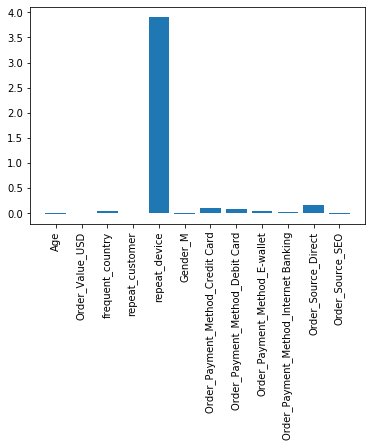

In [268]:

plt.bar('Feature','Coeff',data=coeff_df)
plt.xticks(rotation=90)

In [283]:
# linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda=LinearDiscriminantAnalysis(n_components=1)
lda.fit(X_train,y_train)
lda_features_train=lda.transform(X_train)
lda_features_test=lda.transform(X_test)

y_pred_train=lda.predict(X_train)
y_pred_test=lda.predict(X_test)
f1_score(y_test,y_pred_test)

0.2832764505119454

No handles with labels found to put in legend.


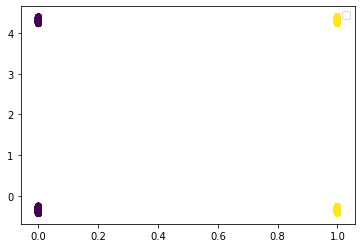

In [289]:
x1=lda_features_train
# visualizing data

label=[]
colors=[]
for i in y_train:
    if i==1:
        label.append(1)
        colors.append('red')
    else: 
        label.append(0)
        colors.append('green')
    
plt.scatter(y_train,x1,c=label)
plt.legend()

In [254]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier(class_weight='balanced')
clf.fit(X_train,y_train)

y_pred_train=logreg.predict(X_train)
y_pred_test=logreg.predict(X_test)
f1_score(y_test,y_pred_test)

0.2832764505119454

In [259]:
# random forest
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_jobs=3)
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=143)

param_grid = {"n_estimators" : [150, 250,300],
              "max_depth" : [4,8],
              "max_features" : [3, 5, 7],
              "min_samples_leaf" : [4, 6, 8]}

rf_grid = GridSearchCV(clf, param_grid= param_grid, cv=kfold)

In [260]:
%%time
rf_grid.fit(X_train,y_train)


Wall time: 4min 11s


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=143, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=3,
                                              

In [261]:
rf_grid.best_params_

{'max_depth': 8, 'max_features': 5, 'min_samples_leaf': 4, 'n_estimators': 300}

In [293]:
#KNN classification
from sklearn.neighbors import KNeighborsClassifier

model2= KNeighborsClassifier(n_neighbors=6,metric='euclidean')
model2.fit(X_train,y_train)
y_pred_train=model2.predict(X_train)
y_pred_test=model2.predict(X_test)
print(f1_score(y_train,y_pred_train))
print(f1_score(y_test,y_pred_test))

0.6064427690198766
0.23826714801444043


In [274]:
# gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
clf=GradientBoostingClassifier(random_state=123)

In [295]:
%%time
gbm_param_grid = {'max_depth': [2,4,8], 'subsample': [0.8, 0.6,], 'max_features':[0.2,0.3,0.4], 
              'n_estimators': [ 100,200,300]}

gbm_grid = GridSearchCV(clf, param_grid=gbm_param_grid, cv=3,n_jobs=-1)

gbm_grid.fit(X_train,y_train)

Wall time: 3min


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [296]:
gbm_grid.best_params_

{'max_depth': 2, 'max_features': 0.3, 'n_estimators': 300, 'subsample': 0.6}

In [297]:
y_pred_train=gbm_grid.predict(X_train)
y_pred_test=gbm_grid.predict(X_test)
print(f1_score(y_train,y_pred_train))
print(f1_score(y_test,y_pred_test))

0.6287842383469485
0.2832764505119454


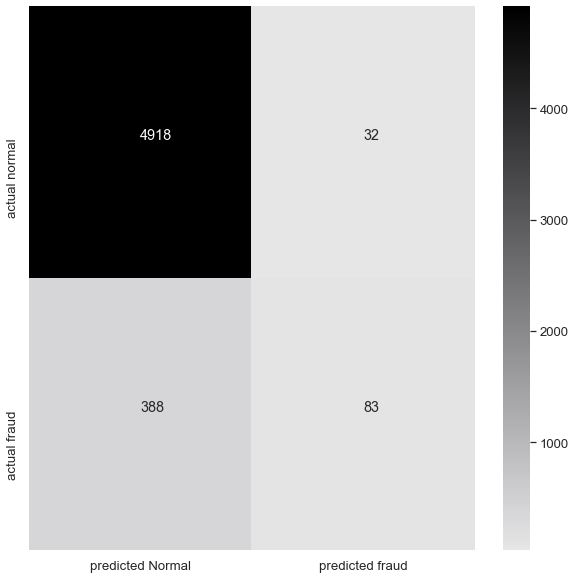

In [303]:
conf=confusion_matrix(y_test,y_pred_test)
cmap=sns.cubehelix_palette(50,hue=0.05,rot=0,light=0.9,dark=0,as_cmap=True)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.2)
akws = {"ha": 'left',"va": 'bottom'}
sns.heatmap(conf,cmap=cmap,xticklabels=['predicted Normal','predicted fraud'],yticklabels=['actual normal','actual fraud'],annot=True,fmt='d',annot_kws=akws)


# exporting to csv

In [262]:
y_pred_train=rf_grid.predict(X_train)
y_pred_test=rf_grid.predict(X_test)
f1_score(y_test,y_pred_test)

0.2832764505119454

In [272]:
forecast=rf_grid.predict(final_2)
final_2['outcome']=forecast
df=final_2.outcome
df.to_csv('forecast.csv',index=True,header=True)